In [1]:
import sys
import os
import json
import pickle
from mmdet3d.datasets.pipelines import Compose
import mmcv
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# change working directory
os.chdir(
    "/home/ensai/Documents/msd06-1-smart-data-project/LIDC/MV2Dmain/MV2Dbasedlifting"
)
print("Current Working Directory:", os.getcwd())

from mmdet3d_plugin import CustomLIDCDataset

data_root_lidc = "./data/lidc/"

lidc_dataclass = CustomLIDCDataset(
    data_root=data_root_lidc,
    ann_file=data_root_lidc + "toy_infos.pkl",
    ann_file_2d=data_root_lidc + "toy_infos_2d_anno.coco.json",
)

Current Working Directory: /home/ensai/Documents/msd06-1-smart-data-project/LIDC/MV2Dmain/MV2Dbasedlifting
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


dict_keys(['sample_idx', 'img_timestamp', 'img_filename', 'lidar2img', 'intrinsics', 'extrinsics', 'img_info', 'ann_info'])


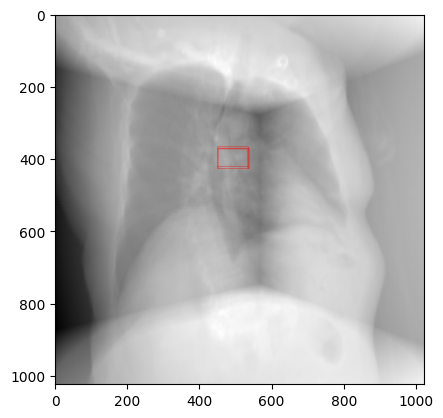

In [53]:
#
# Read ground truth anno
#
p0 = lidc_dataclass.get_data_info(0)
print(p0.keys())
p0["img_info"]

# get image
cam_idx = 9

img_path = p0["img_info"]["cams"][f"CAM_{cam_idx:02d}"]["data_path"]
img = mmcv.imread(img_path)

# get gt bbox 2d
gt_bbox2d = p0["ann_info"]["gt_bboxes_2d"][cam_idx]
gt_bbox2d

img_gtbbox = mmcv.imshow_bboxes(img, gt_bbox2d, colors="blue", show=False)
plt.imshow(img_gtbbox)

In [65]:
#
# Read detection FPN features
#

with open("./debug_var/eval_2ddet/detector_feat.pkl", "rb") as f:
    detector_feat = pickle.load(f)  # 5 levels of FPN

len(detector_feat)

detector_feat[4].shape

torch.Size([10, 256, 8, 8])

torch.Size([256, 128, 128])
torch.Size([256, 64, 64])
torch.Size([256, 32, 32])
torch.Size([256, 16, 16])
torch.Size([256, 8, 8])


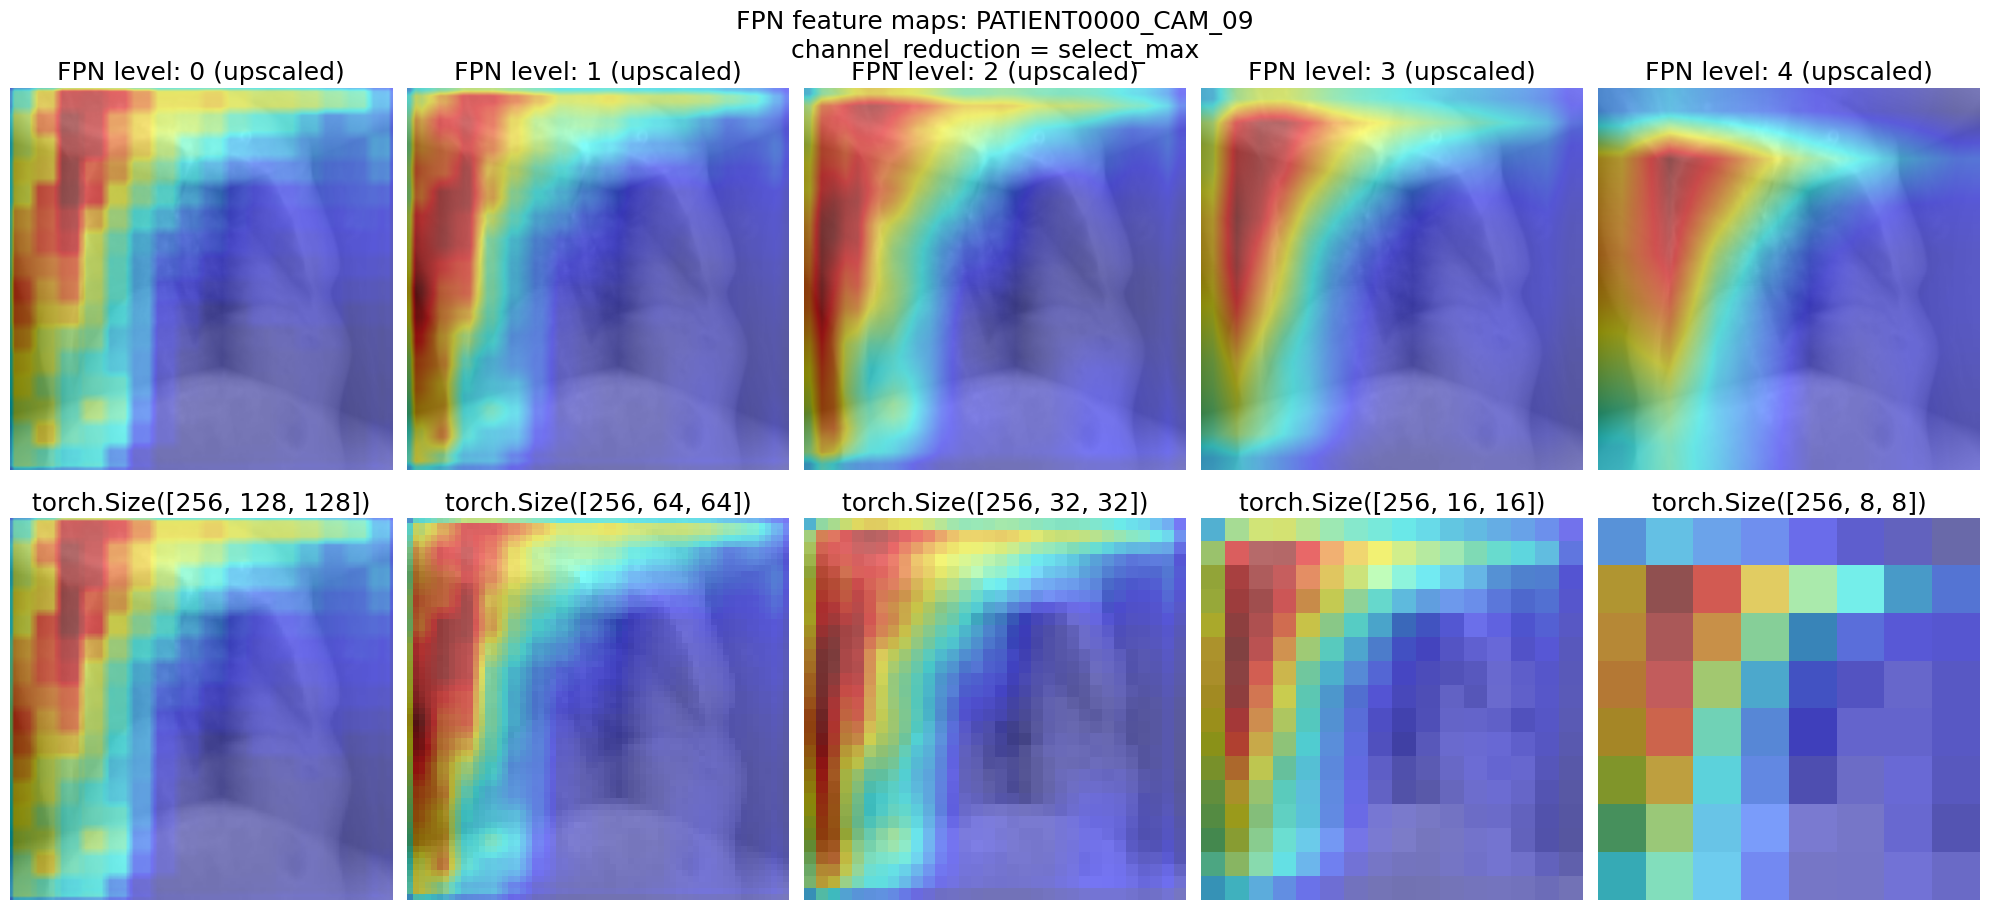

In [70]:
import torch
import mmcv
from mmengine.visualization import Visualizer

visualizer = Visualizer()


fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# channel = 10
cam_idx = 9

img_path = p0["img_info"]["cams"][f"CAM_{cam_idx:02d}"]["data_path"]
img = mmcv.imread(img_path)
reduction_type = "select_max"  # select_max or squeeze_mean

for i, fpn in enumerate(detector_feat):
    # Get the first image's channel 0
    feat = fpn[cam_idx]
    s = feat.shape
    print(s)

    # reshape img to feat size
    d_img = mmcv.imrescale(img, s[1:3])

    # Plot 5 levels for 1 channel
    ax = axes[0, i]
    feat_map_img = visualizer.draw_featmap(feat, img, channel_reduction=reduction_type)
    ax.imshow(feat_map_img)
    # ax.imshow(feat.cpu().numpy(), alpha=0.5)
    ax.axis("off")
    ax.set_title(f"FPN level: {i} (upscaled)", fontsize=18)

    d_ax = axes[1, i]
    d_feat_map_img = visualizer.draw_featmap(
        feat, d_img, channel_reduction=reduction_type
    )
    d_ax.imshow(d_feat_map_img)
    d_ax.axis("off")
    d_ax.set_title(f"{feat.shape}", fontsize=18)

plt.suptitle(
    f"FPN feature maps: PATIENT0000_CAM_{cam_idx:02d}\nchannel_reduction = {reduction_type}",
    size=18,
    y=0.95,
)
plt.tight_layout()
plt.show()
# plt.savefig(f"debug_var/figures/fpn-feat-{reduction_type}.png")

(-0.5, 1279.5, 511.5, -0.5)

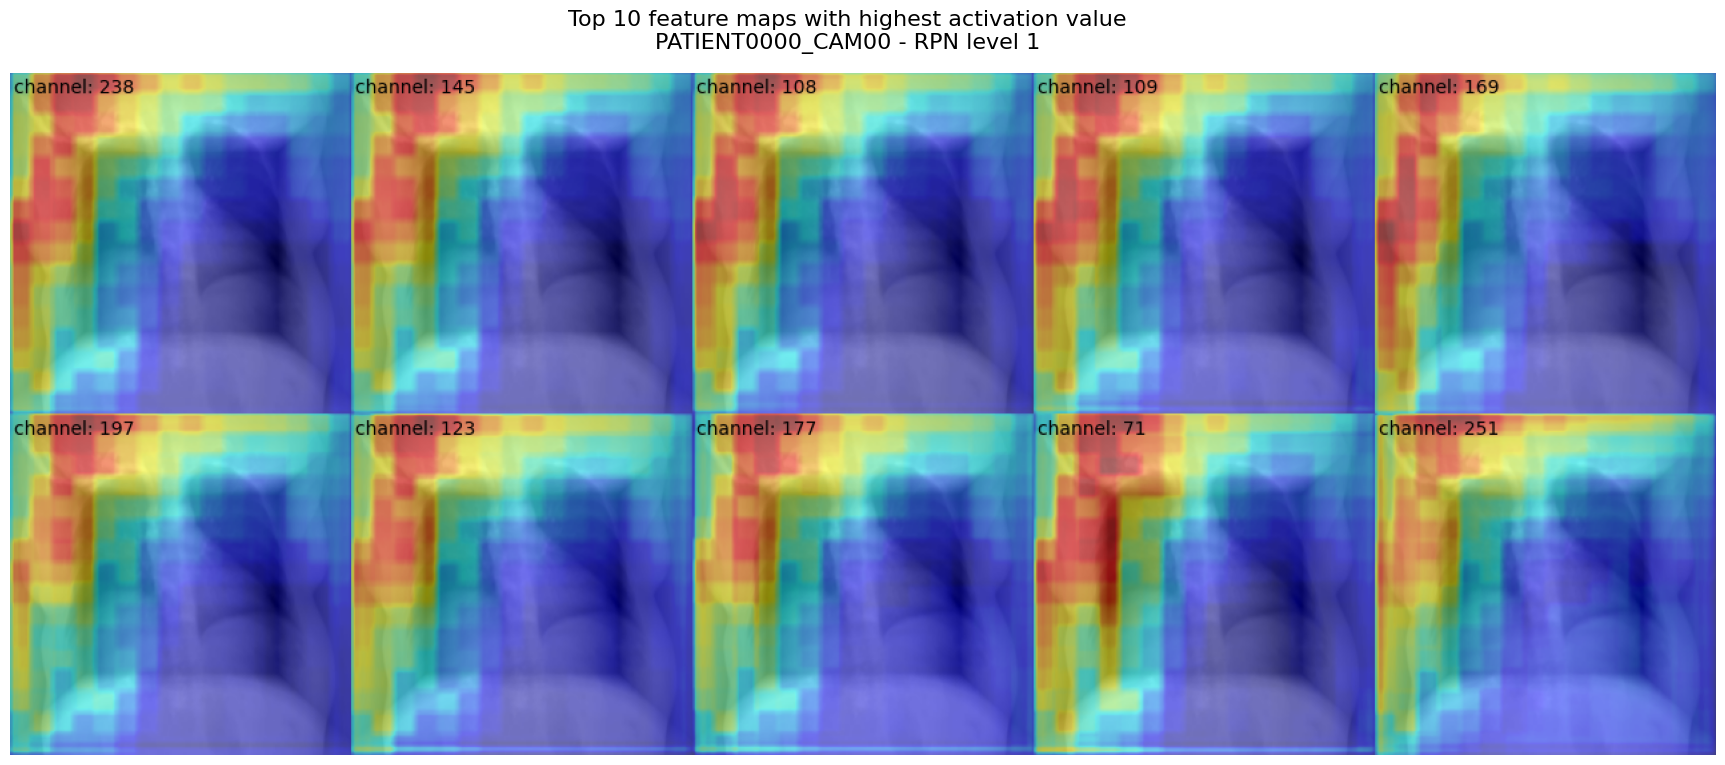

In [68]:
#
# Visualize top10 channel for 1 level
#


idx = 0
img_path = p0["img_info"]["cams"][f"CAM_{idx:02d}"]["data_path"]
img = mmcv.imread(img_path)
d_img = mmcv.imresize(img, (256, 256))


visualizer = Visualizer()

feat = detector_feat[0][idx]
feat_map_img = visualizer.draw_featmap(
    feat, d_img, channel_reduction=None, topk=10, arrangement=(2, 5)
)


# visualizer.show(feat_map_img)
plt.figure(figsize=(20, 8))
plt.imshow(feat_map_img)
plt.suptitle(
    f"Top 10 feature maps with highest activation value\nPATIENT0000_CAM{idx:02d} - RPN level 1",
    fontsize=16,
)
plt.tight_layout()
plt.axis("off")

In [42]:
detector_feat[0].shape

torch.Size([10, 256, 128, 128])

Text(0.5, 1.0, 'Region proposals for Patient0000_cam00\ntensor shape: (1000, 5)')

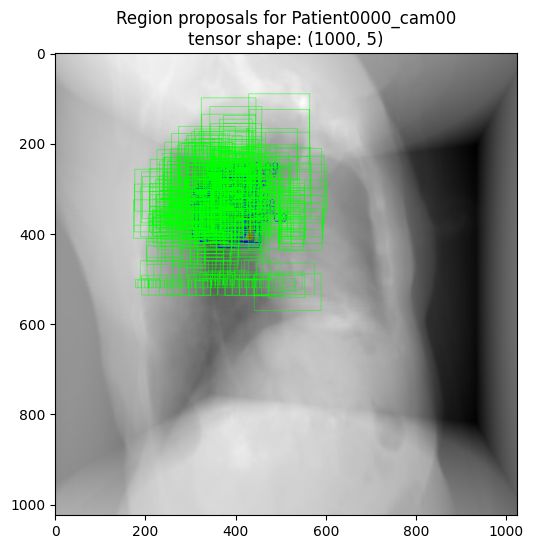

In [ ]:
#
# Read region_proposal for 2D Detecion
#

with open("./debug_var/eval_2ddet/proposal_list.pkl", "rb") as f:
    proposal_list = pickle.load(f)


proposal_list = [p.cpu().numpy() for p in proposal_list]
prop = proposal_list[0]

img_with_proposal = mmcv.imshow_bboxes(
    img=img_gtbbox,
    bboxes=prop[:, :4],
    # labels=labels,
    colors="green",
    thickness=1,
    show=False,
)

plt.figure(figsize=(8, 6))
plt.imshow(img_with_proposal)
plt.title(f"Region proposals for Patient0000_cam00\ntensor shape: {prop.shape}")

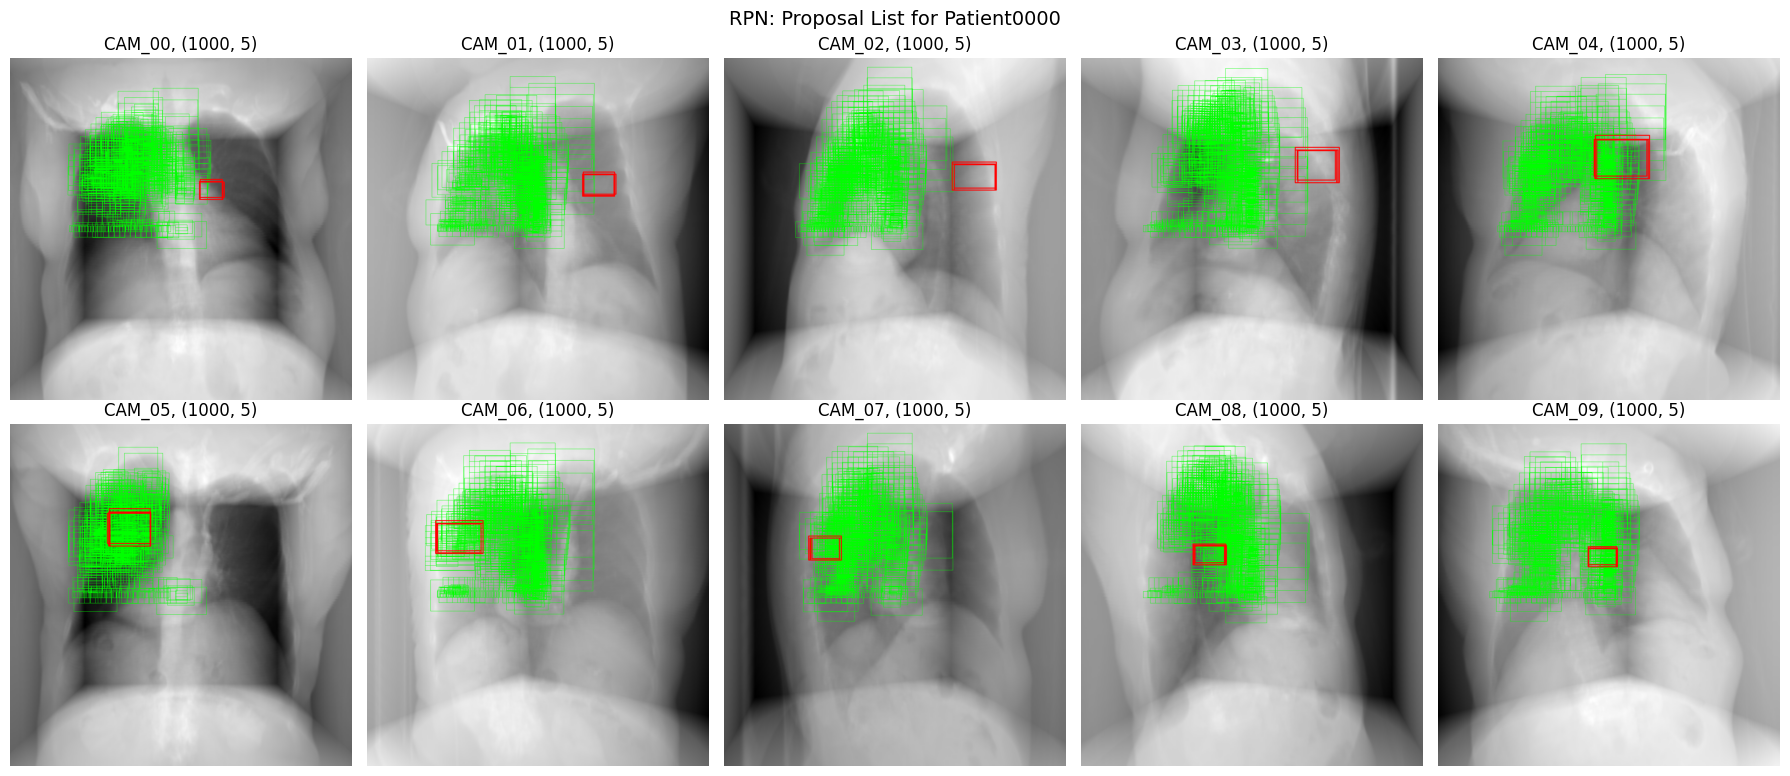

In [73]:
#
# Plot region proposal for all cam
#

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle("RPN: Proposal List for Patient0000", fontsize=14)

for i in range(10):
    img_path = p0["img_info"]["cams"][f"CAM_{i:02d}"]["data_path"]
    img = mmcv.imread(img_path)

    # get gt bbox 2d
    gt_bbox2d = p0["ann_info"]["gt_bboxes_2d"][i]
    gt_bbox2d

    prop = proposal_list[i]
    img_with_proposal = mmcv.imshow_bboxes(
        img=img,
        bboxes=prop[:, :4],
        # labels=labels,
        colors="green",
        # thickness=1,
        show=False,
    )

    img_gtbbox = mmcv.imshow_bboxes(
        img_with_proposal, gt_bbox2d, colors="blue", show=False, thickness=2
    )

    row, col = divmod(i, 5)
    ax = axes[row, col]
    # ax = plt.subplot(2, 5, i+1)
    ax.imshow(img_gtbbox)
    ax.set_title(f"CAM_{i:02d}, {prop.shape}")
    ax.axis("off")

plt.tight_layout()
plt.show()
# plt.savefig("debug_var/figures/img-proposal.png")

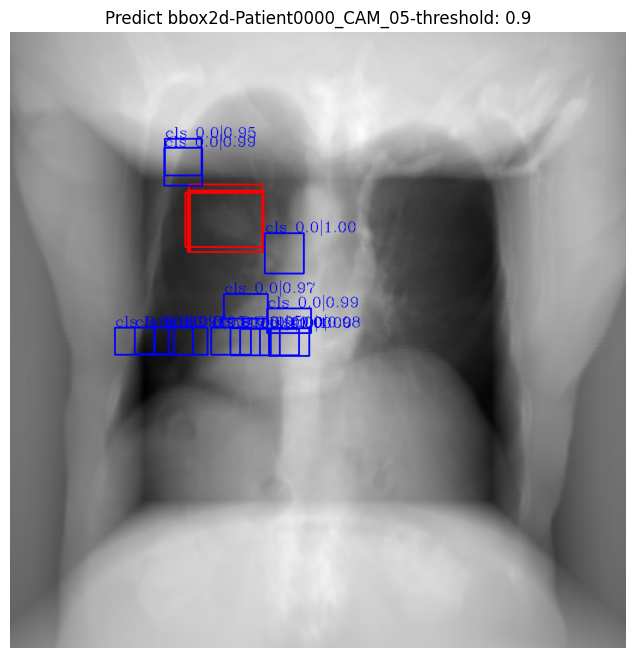

In [78]:
#
# Read 2D Detection bbox results
#

# with open("./debug_var/eval_2ddet/2dbbox_det_processed.pkl", "rb") as f:
#     det_bbox2d = pickle.load(f)

with open("./debug_var/eval_2ddet/2dbbox_det_processed.pkl", "rb") as f:
    det_bbox2d = pickle.load(f)

det_bbox2d = [bbox.cpu().numpy() for bbox in det_bbox2d]

idx = 5
threshold = 0.9

img_path = p0["img_info"]["cams"][f"CAM_{idx:02d}"]["data_path"]
img = mmcv.imread(img_path)

# get gt bbox 2d
gt_bbox2d = p0["ann_info"]["gt_bboxes_2d"][idx]
gt_bbox2d

img_gtbbox = mmcv.imshow_bboxes(img, gt_bbox2d, colors="blue", show=False, thickness=2)

# get det_bbox2d
det_bbox = det_bbox2d[idx]
det_bbox = det_bbox[np.where(det_bbox[..., 4] > threshold)]
# print(det_bbox.shape)

img_with_detbbox = mmcv.imshow_det_bboxes(
    img=img_gtbbox,
    bboxes=det_bbox[:, :5],
    labels=det_bbox[:, 5],
    score_thr=threshold,
    text_color="red",
    bbox_color="red",
    font_scale=0.8,
    thickness=2,
    show=False,
)


plt.figure(figsize=(8, 8))
plt.imshow(img_with_detbbox)
plt.axis("off")
plt.title(f"Predict bbox2d-Patient0000_CAM_{idx:02d}-threshold: {threshold}")
plt.show()

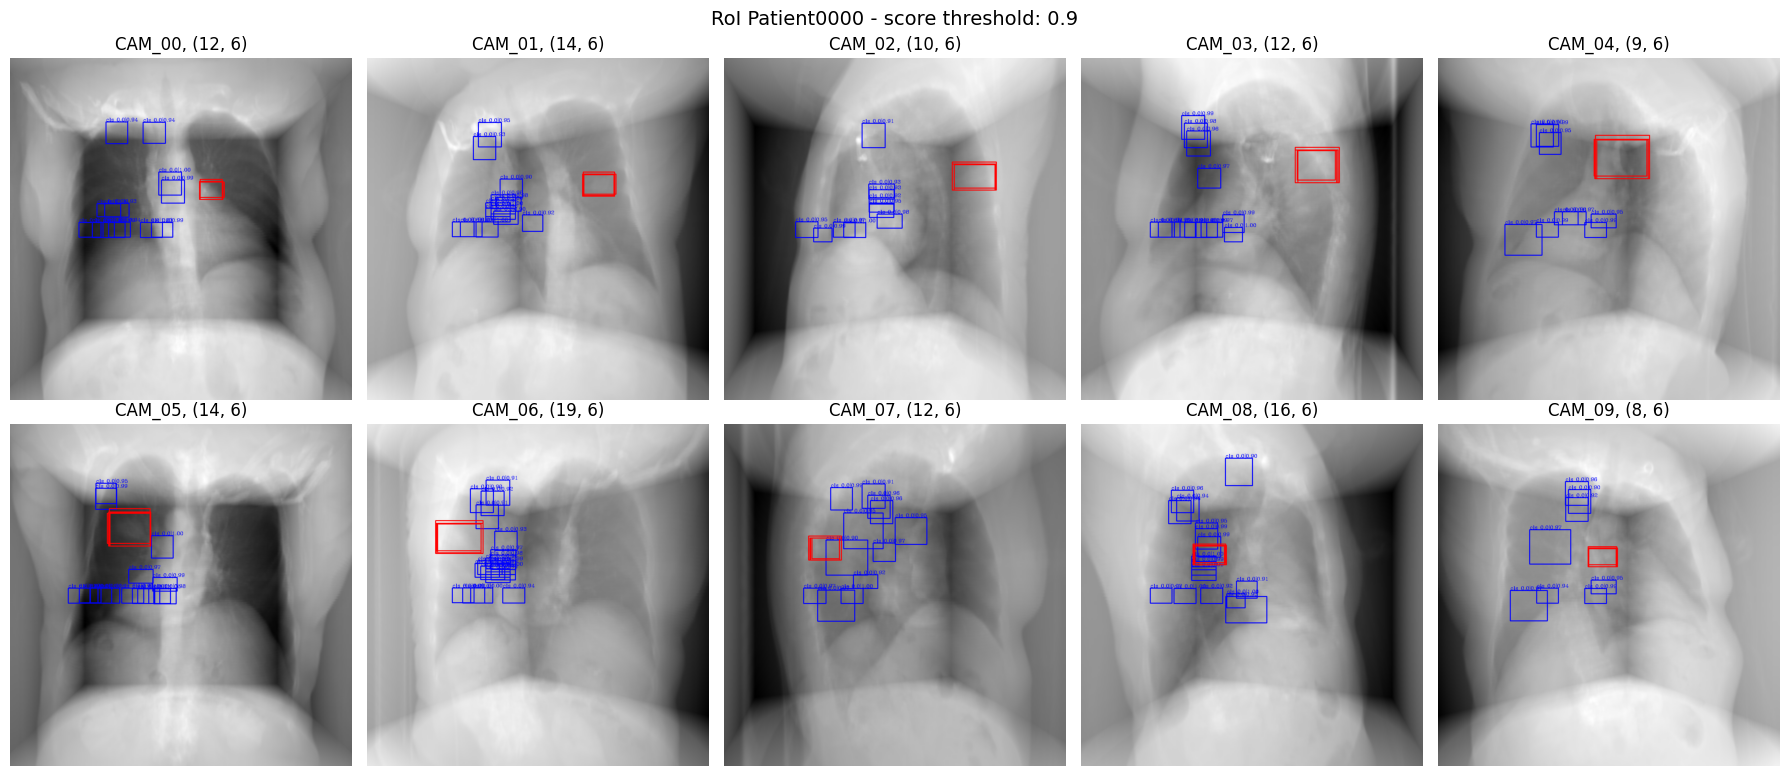

In [49]:
#
# Plot RoI for all cam
#

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
threshold = 0.9
fig.suptitle(f"RoI Patient0000 - score threshold: {threshold}", fontsize=14)


for i in range(10):
    img_path = p0["img_info"]["cams"][f"CAM_{i:02d}"]["data_path"]
    img = mmcv.imread(img_path)

    # get gt bbox 2d
    gt_bbox2d = p0["ann_info"]["gt_bboxes_2d"][i]
    gt_bbox2d

    # get 2d pred bbox
    det_bbox = det_bbox2d[i]
    det_bbox = det_bbox[np.where(det_bbox[..., 4] > threshold)]

    # img_w_detbbox = mmcv.imshow_bboxes(
    #     img=img,
    #     bboxes=det_bbox[:, :4],
    #     # labels=labels,
    #     colors="red",
    #     thickness=2,
    #     show=False,
    # )

    img_with_detbbox = mmcv.imshow_det_bboxes(
        img=img,
        bboxes=det_bbox[:, :5],
        labels=det_bbox[:, 5],
        score_thr=threshold,
        text_color="red",
        bbox_color="red",
        thickness=2,
        show=False,
    )

    img_gtbbox = mmcv.imshow_bboxes(
        img_with_detbbox, gt_bbox2d, colors="blue", show=False, thickness=2
    )

    row, col = divmod(i, 5)
    ax = axes[row, col]
    # ax = plt.subplot(2, 5, i+1)
    ax.imshow(img_gtbbox)
    ax.set_title(f"CAM_{i:02d}, {det_bbox.shape}")
    ax.axis("off")

plt.tight_layout()
plt.show()
# plt.savefig("debug_var/figures/img-roi-threshold09.png")

In [39]:
#
# Read feature maps
#

with open("./debug_var/eval_2ddet/feat.pkl", "rb") as f:
    feats = pickle.load(f)


# feats = [f.cpu().numpy() for f in feat[0]]

In [40]:
feats[0].shape

torch.Size([10, 256, 32, 32])

(-0.5, 1279.5, 511.5, -0.5)

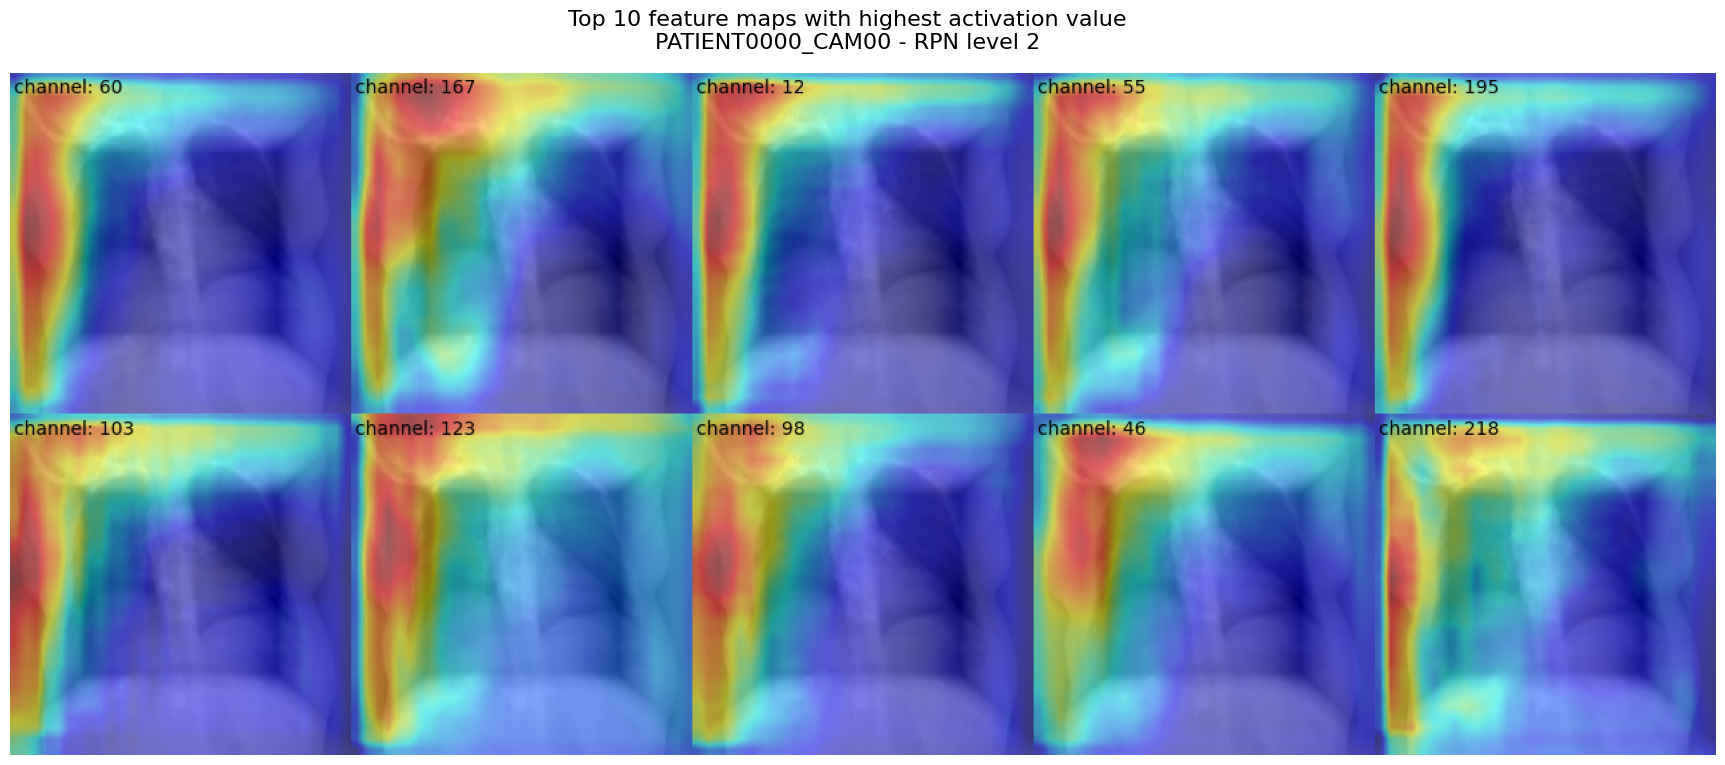

In [68]:
#
# Visualize feature map
#

import torch
import mmcv
from mmengine.visualization import Visualizer


idx = 0
img_path = p0["img_info"]["cams"][f"CAM_{idx:02d}"]["data_path"]
img = mmcv.imread(img_path)
d_img = mmcv.imresize(img, (256, 256))


visualizer = Visualizer()

feat = feats[0][idx]
feat_map_img = visualizer.draw_featmap(
    feat, d_img, channel_reduction=None, topk=10, arrangement=(2, 5)
)


# visualizer.show(feat_map_img)
plt.figure(figsize=(20, 8))
plt.imshow(feat_map_img)
plt.suptitle(
    f"Top 10 feature maps with highest activation value\nPATIENT0000_CAM{idx:02d} - RPN level 2",
    fontsize=16,
)
plt.tight_layout()
plt.axis("off")

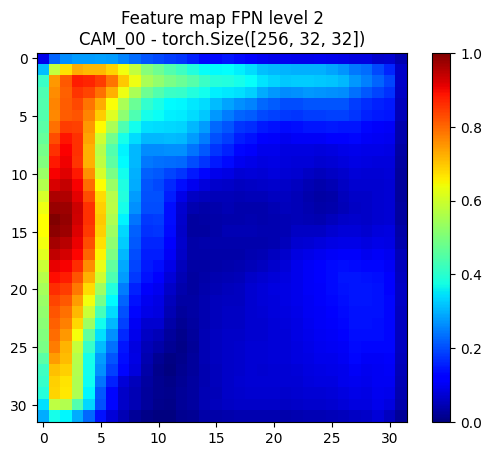

In [47]:
idx = 0
feat = feats[0][idx]

feat_map = visualizer.draw_featmap(feat, channel_reduction="select_max")
plt.imshow(feat_map)
plt.title(f"Feature map FPN level 2\nCAM_{idx:02d} - {feat.shape}")

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="jet"), orientation="vertical")
# cbar.set_label("Intensity")


plt.show()

In [11]:
with open("./debug_var/eval_2ddet/detector_feat.pkl", "rb") as f:
    det_feat = pickle.load(f)

In [15]:
len(det_feat)
det_feat[0].cpu()

tensor([[[[ 5.0382e+00,  4.6822e+00,  6.1771e+00,  ...,  1.5352e+00,
            1.2603e-01,  4.7444e+00],
          [ 1.6942e+01,  1.1127e+01,  1.2743e+01,  ..., -3.1410e+00,
           -5.0614e+00,  2.1810e+00],
          [ 1.5825e+01,  1.0509e+01,  1.1598e+01,  ..., -5.2021e+00,
           -6.6049e+00,  1.9313e+00],
          ...,
          [ 7.6364e+00,  2.7679e+00,  1.7276e+00,  ..., -1.5402e+01,
           -1.4485e+01,  1.3651e+00],
          [ 9.0505e+00,  5.3394e+00,  5.9021e+00,  ..., -1.0433e+01,
           -1.0744e+01,  3.9853e+00],
          [ 1.1057e+01,  1.6579e+00,  1.9573e+00,  ..., -9.3102e+00,
           -9.7048e+00,  3.5640e-01]],

         [[-6.1967e+00,  1.5843e+01,  1.6486e+01,  ...,  1.3563e+01,
            1.3891e+01,  4.0474e+00],
          [-1.1027e+01,  9.6132e+00,  9.7791e+00,  ...,  1.5075e+01,
            1.5962e+01,  1.0466e-01],
          [-1.2708e+01,  8.0238e+00,  9.8437e+00,  ...,  1.4463e+01,
            1.4102e+01, -1.4129e+00],
          ...,
     